# Weather file - visualization
- Main task: visualizing weather station locations, yield, & climatology of sites
- Main input:
    - weather station list & detail
    - USDA NASS maize yield data
    - compiled weater data (temp, rh, precip, solrad)
- Main output: 
    - weather stations map
    - yield map & station locations
    - climatology: temp & precip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

from scipy.stats.stats import pearsonr
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import RdPu_5
from palettable.colorbrewer.sequential import Purples_9

### 1. Overall site-year coverage

Text(0.5, 0, 'stations')

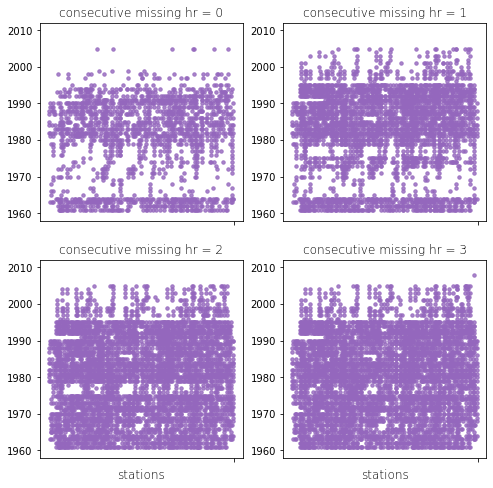

In [3]:
siteyear_ctr0 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr0.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr1 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv',
                           dtype={'site': object}, usecols=[1,2])
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv',
                           dtype={'site': object}, usecols=[1,2]) 
siteyear_ctr3 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr3.csv',
                           dtype={'site': object}, usecols=[1,2]) 

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(siteyear_ctr0.site, siteyear_ctr0.year, alpha=0.8, color='tab:purple', s=12)
ax1.set_ylim(1958, 2012)
ax1.set_xticks('')
ax1.set_title('consecutive missing hr = 0', fontweight='light')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(siteyear_ctr1.site, siteyear_ctr1.year, alpha=0.8, color='tab:purple', s=12)
ax2.set_ylim(1958, 2012)
ax2.set_xticks('')
ax2.set_title('consecutive missing hr = 1', fontweight='light')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(siteyear_ctr2.site, siteyear_ctr2.year, alpha=0.8, color='tab:purple', s=12)
ax3.set_ylim(1958, 2012)
ax3.set_xticks('')
ax3.set_title('consecutive missing hr = 2', fontweight='light')
ax3.set_xlabel('stations', fontsize=12, fontweight='light')

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(siteyear_ctr3.site, siteyear_ctr3.year, alpha=0.8, color='tab:purple', s=12)
ax4.set_ylim(1958, 2012)
ax4.set_xticks('')
ax4.set_title('consecutive missing hr = 3', fontweight='light')
ax4.set_xlabel('stations', fontsize=12, fontweight='light')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/siteyears.png', format='png', dpi=800)

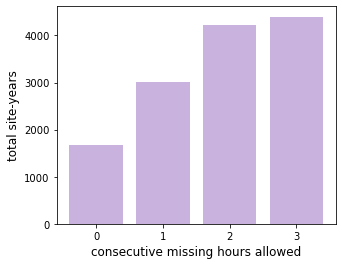

In [4]:
siteyears_ctr0 = siteyear_ctr0.shape[0]
siteyears_ctr1 = siteyear_ctr1.shape[0]
siteyears_ctr2 = siteyear_ctr2.shape[0]
siteyears_ctr3 = siteyear_ctr3.shape[0]

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ctrhr = [0,1,2,3]
siteyears = [siteyears_ctr0, siteyears_ctr1, siteyears_ctr2, siteyears_ctr3]
ax.bar(ctrhr, siteyears, alpha=0.5, color='tab:purple')
ax.set_xlabel('consecutive missing hours allowed', fontsize=12)
ax.set_ylabel('total site-years', fontsize=12)
ax.set_xticks([0,1,2,3])

### 2. Stations map - critical hour: 2

In [2]:
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', index_col=0)
df_summary.head()

,class,station,state,tzone,lat,lon,years,area,perct_irri
site,,,,,,,,,
722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25,101.171570,60.802507
722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29,374.334800,61.901377
722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19,647.498030,78.435473
722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19,607.029392,55.098924
722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19,558.467041,50.088347


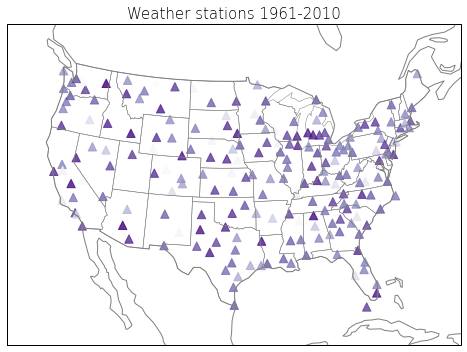

In [7]:
# creating map with weather station sites only
from palettable.colorbrewer.sequential import Purples_9

# sites not filtered
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(df_summary.lon, df_summary.lat, transform=ccrs.PlateCarree(), s=70, marker='^',
            c=df_summary.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Weather stations 1961-2010', fontweight='light', fontsize=15)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation.png', format='png', dpi=800)

### 3. Filtering based on irrigation & planting area

In [9]:
df_obs = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/obs_areairri.csv', index_col=0)
df_obs.head()

,state_id,county_id,lat,lon,area,state,county,perct_irri
0,1.0,1.0,32.462991,-86.709691,6758.2607,1.0,1.0,2.112183
1,1.0,3.0,30.787262,-87.712913,19748.6900,1.0,3.0,8.510410
2,1.0,5.0,31.870087,-85.383129,11452.6210,1.0,5.0,4.945534
3,1.0,7.0,33.072877,-87.112698,2092.2280,1.0,7.0,0.624115
4,1.0,9.0,33.988350,-86.613622,10064.5470,1.0,9.0,0.940536


/home/disk/eos8/ach315/anaconda3/envs/ideotype/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


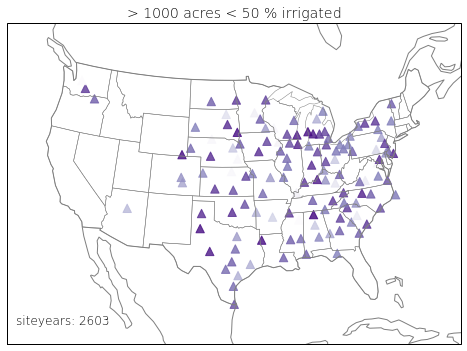

In [20]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]     
ax.scatter(df_filtered.lon, df_filtered.lat, 
           transform=ccrs.PlateCarree(), s=70, marker='^', 
           c=df_filtered.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('> 1000 acres < 50 % irrigated',
             fontweight='light', fontsize=14)
ax.text(-112, 23, 'siteyears: {}'.format(df_filtered.years.sum()),
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=12)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.2)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation_filtered.png', format='png', dpi=800)

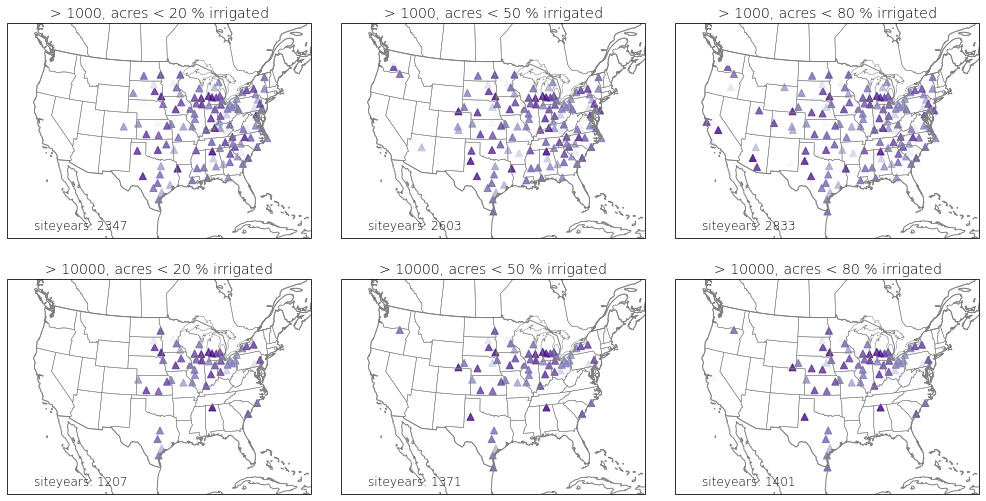

In [9]:
# set filtering threshold for planting area & irrigation percentage
area = [1000, 1000, 1000, 10000, 10000, 10000]
irri = [20, 50, 80, 20, 50, 80]

# sites not filtered
fig = plt.figure(figsize=(15,8))

for i in np.arange(1,7):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    df_filtered = df_summary[(df_summary.area > area[i-1]) & (df_summary.perct_irri < irri[i-1])]     
    ax.scatter(df_filtered.lon, df_filtered.lat, 
               transform=ccrs.PlateCarree(), s=50, marker='^', 
               c=df_filtered.years, cmap=Purples_9.mpl_colormap, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('> {}, acres < {} % irrigated'.format(area[i-1], irri[i-1]),
                 fontweight='light', fontsize=14)
    ax.text(-103, 23, 'siteyears: {}'.format(df_filtered.years.sum()),
            horizontalalignment='right', transform=ccrs.PlateCarree(),
            fontweight='light', fontsize=12)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/stations_filters.png', format='png', dpi=800)

### 4. Climate Space & Climatology

In [10]:
# weather data for individual site-years
df_siteyears_weamean = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', 
                                   index_col=0, dtype={'site': str})

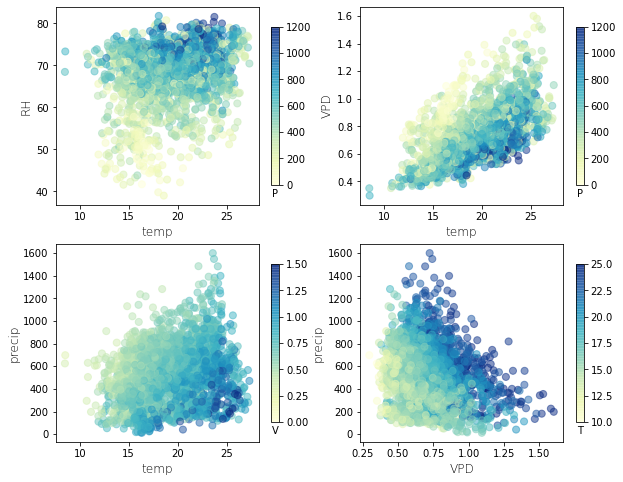

In [11]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(10,8))

#cm = plt.cm.get_cmap('YlGnBu')
temp_all = df_siteyears_weamean.temp
rh_all = df_siteyears_weamean.rh
precip_all = df_siteyears_weamean.precip
vpd_all = df_siteyears_weamean.vpd

weadata = [[temp_all, rh_all, precip_all], [temp_all, vpd_all, precip_all],
           [temp_all, precip_all, vpd_all], [vpd_all, precip_all, temp_all]]

titles = [['temp', 'RH', 'P'], ['temp', 'VPD', 'P'], 
          ['temp', 'precip', 'V'], ['VPD', 'precip', 'T']]

ranges = [[0,1200], [0,1200], [0,1.5], [10,25]]

for i in np.arange(4):
    ax = fig.add_subplot(2,2,i+1)
    sc = ax.scatter(weadata[i][0], weadata[i][1], c=weadata[i][2],
                    alpha=0.5, s=50, vmin=ranges[i][0], vmax=ranges[i][1], cmap=YlGnBu_8.mpl_colormap)
    ax.set_xlabel(titles[i][0], fontsize=12, fontweight='light')
    ax.set_ylabel(titles[i][1], fontsize=12, fontweight='light')
    cbar = fig.colorbar(sc, shrink=0.8)
    cbar.ax.set_xlabel(titles[i][2])



### Averaging based on sites

In [12]:
# site-mean wea data
df_sitemeans = df_siteyears_weamean.groupby('site').mean()

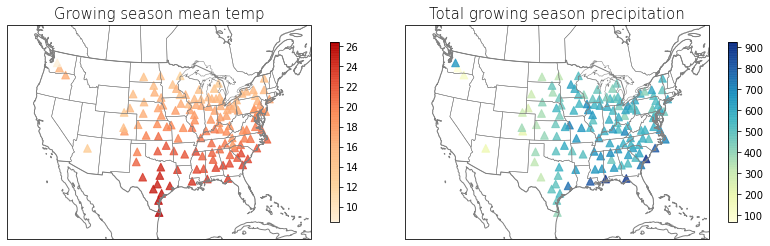

In [13]:
# setting up figure
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_sitemeans.lon, df_sitemeans.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=df_sitemeans.temp, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_sitemeans.lon, df_sitemeans.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=df_sitemeans.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Total growing season precipitation', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/climate_map.png', format='png', dpi=800)

### Plotting for specific year

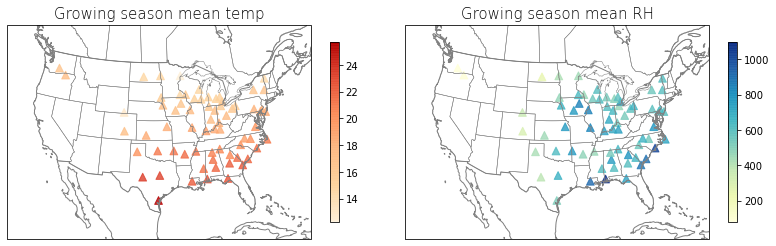

In [14]:
# subset of year
df_year = df_siteyears_weamean[df_siteyears_weamean.year==1961]

# setting up figure
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
mp1 = ax1.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                  s=60, marker='^', c=df_year.temp, cmap=OrRd_6.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.set_title('Growing season mean temp', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp1, shrink=0.5)

ax2 = fig.add_subplot(1,2,2, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax2.set_extent([-123, -72, 19, 53])
mp2 = ax2.scatter(df_year.lon, df_year.lat, transform=ccrs.PlateCarree(), 
                 s=60, marker='^', c=df_year.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.8)
ax2.add_feature(cfeature.BORDERS, edgecolor='grey')
ax2.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax2.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax2.set_title('Growing season mean RH', fontweight='light', fontsize=15)
cbar = fig.colorbar(mp2, shrink=0.5)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.05)

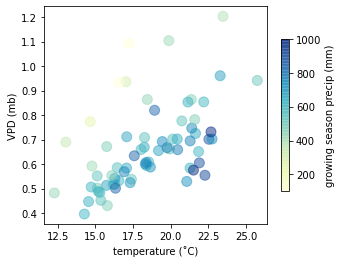

In [15]:
# subset of year
df_year = df_siteyears_weamean[df_siteyears_weamean.year==1961]

fig = plt.figure(figsize=(5,4))
sc = plt.scatter(df_year.temp, df_year.vpd, c=df_year.precip, cmap=YlGnBu_8.mpl_colormap,
                 alpha=0.5, s=100, vmin=100, vmax=1000)
plt.xlabel('temperature (˚C)')
plt.ylabel('VPD (mb)')
cbar = fig.colorbar(sc, shrink=0.7)
cbar.set_label('growing season precip (mm)')

### 5.. Overlay site locations with past yield data
- Main input:
    - /data/NASS_cropdata/**stateID.txt**
    - /data/NASS_cropdata/**countyID.txt**
    - /data/NASS_cropdata/**lat_county.txt**
    - /data/NASS_cropdata/**lon_county.txt**
    - /data/NASS_cropdata/**corn_yield.txt**
    - /data/NASS_cropdata/**corn_area.txt**   
- Main output:
    - /figs/**sites_obsyield.png**

#### 5.1 Reading in USDA NASS yield data

In [16]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years

# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)

# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], var_name='year', value_name='yield')
df = pd.concat([df, cornarea], axis=1)
print(df.shape)

(326340, 7)


#### 5.2 Subsetting data for year 1961-2010

In [17]:
df_subset = pd.DataFrame()
years = np.arange(1961,2010)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_subset = pd.concat([df_subset, data])

# calculating mean yield & area planted across 1961-1990
df_sitemean = df_subset.groupby(['state_id', 'county_id']).mean()
df_sitemean = df_sitemean.reset_index()

#### 5.3 Visualization

Text(0, 0.5, 'yield (tons/ha)')

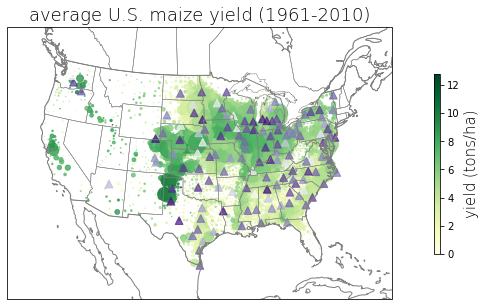

In [18]:
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

# units used to convert maize yield
lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

# filtering sites from df_summary 
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]     

# setting up figure
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sitemean['lon'], df_sitemean['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax.scatter(df_filtered.lon.astype(float), df_filtered.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=60, marker='^',
           c=df_filtered.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)
ax.set_title('Site Locations', fontweight='light', fontsize=18)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('average U.S. maize yield (1961-2010)', 
              fontweight='light', fontsize=18)

yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)', fontweight='light', fontsize=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_obsyield.png', format='png', dpi=800)

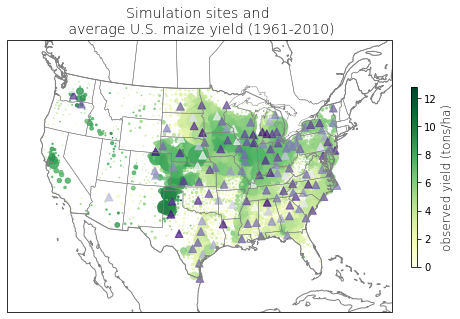

In [41]:
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import Purples_9

# units used to convert maize yield
lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

# filtering sites from df_summary 
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]     

# setting up figure
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_sitemean['lon'], df_sitemean['lat'], 
           transform=ccrs.PlateCarree(), 
           c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
           cmap=YlGn_9.mpl_colormap, alpha=0.8)

ax.scatter(df_filtered.lon.astype(float), df_filtered.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=60, marker='^',
           c=df_filtered.years.astype(float), cmap=Purples_9.mpl_colormap, alpha=0.7)
ax.set_title('Site Locations', fontweight='light', fontsize=18)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Simulation sites and \n average U.S. maize yield (1961-2010)', 
              fontweight='light', fontsize=14)

yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.88, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('observed yield (tons/ha)', fontweight='light', fontsize=12)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_obsyield.png', format='png', dpi=800)